In [1]:
from keras import backend as K
from keras.layers import Input, LSTM, RepeatVector, Embedding, TimeDistributed, Dense
from keras.layers import Dropout, BatchNormalization, Multiply
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
from keras.models import load_model
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import tkinter as tk

Using TensorFlow backend.


In [18]:
movie_path = 'imdbSynopsis_v2.csv'
name_path = 'names.csv'
MAX_NUM_WORDS = 2000

In [19]:
names_file = pd.read_csv(name_path, encoding='cp950', header=None)
movies_file = pd.read_csv(movie_path, encoding='latin1', header=None)
movie_size = len(movies_file)

In [38]:
# cate_dict = np.load('category.npy')

In [43]:
# temp_cate = np.zeros((movie_size, 19))
# count = 0
# for i in movies_file[3]:
#     c_list = i.split(',')
#     for t in c_list:
#         temp_cate[count][np.argwhere(cate_dict == t).flatten()] = 1
#     count += 1

In [46]:
# np.save('new_cate', temp_cate)

In [20]:
movie_long_intro = np.array(movies_file[4].values, dtype=str)
movie_story = np.array(movies_file[5].values, dtype=str)
movie_cate = np.load('movie_category.npy')
movie_names = np.array(names_file[0].values, dtype=str)

In [34]:
movie_names

array(['牠', '惡靈古堡6', '歡迎光臨死亡小鎮', '厲陰宅', '恐怖蠟像館', '鬼娃恰吉', '針孔旅社', '鬼關燈',
       '陰兒房', '我的殭屍女兒', '末日z戰', '安娜貝爾', '沉默之丘', '母侵', '鬼入鏡', '辣得要命', '孤兒怨',
       '28周毀滅倒數', '魔山', '屍速列車', '血紅帽', '活人生吃', '海底總動員', '腦筋急轉彎', '動物方程市',
       '玩具總動員', '冰雪奇緣', '魔髮奇緣', '功夫熊貓', '天外奇蹟', '料理鼠王', '馴龍高手', '汽車總動員',
       '怪獸電力公司', '小小兵', '馬達加斯加', '史瑞克', '瓦力', '尖叫旅社', '崖上的波妞', '魔法公主',
       '龍貓', '神隱少女', '貓的報恩', '魔女宅急便', '101忠狗', '獅子王', '借物少女艾莉提', '分裂',
       '逃出絕命鎮', '控制', '迷霧驚魂', '奪魂鋸 ', '絕命終結站', '人形蜈蚣', '黑天鵝', '非禮勿弒',
       '星際效應', '星際異攻隊', '雲端情人', '極樂世界', '魔鬼終結者', '第五元素', '第四類接觸', '鐘點戰',
       '全面啟動', '千鈞一髮', '明日邊界', '超完美嬌妻', '星際過客', '變人', '樂來樂愛你', '曼哈頓練習曲',
       '曼哈頓奇緣', '搖滾教室', '髮膠明星夢', 'K 歌情人', '歌喉讚', '修女也瘋狂', '芝加哥', '紅磨坊',
       '歌舞青春', '放牛班的春天', '悲慘世界', 'In to the woods', '夢幻女郎', '舞孃俱樂部',
       'Mama mia', '走音天后', '歌劇魅影', '鑼鼓喧天', '真善美', '窈窕淑女', '美女與野獸',
       '剪刀手愛德華', '三個傻瓜', '海上鋼琴師', '在深夜加油站遇見蘇格拉底', '心靈捕手', '忠犬小八', '楚門的世界',
       '天生一對', '沒問題先生', '姊姊的守護者', '一路玩到掛', '型男飛行日誌', '美味關係', '逆轉

In [21]:
def tokenize_doc(doc):
    stopWords = set(stopwords.words('english'))
    ps = nltk.stem.PorterStemmer()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    sentence = ""
    words = tokenizer.tokenize(doc)
    for w in words:
        temp = str(ps.stem(w.lower()))
#         if temp not in stopWords:
        sentence += temp + " "
    return sentence

In [22]:
train_intro = []
train_story = []
for i in range(movie_size):
    s_long_intro = tokenize_doc(movie_long_intro[i])
    train_intro.append(s_long_intro)
    s_story = tokenize_doc(movie_story[i])
    train_story.append(s_story)

In [17]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(np.concatenate((train_intro, train_story)))

In [23]:
intro_sequences = tokenizer.texts_to_sequences(train_intro)
intro_matrix = tokenizer.sequences_to_matrix(intro_sequences, mode='count')
# for i in range(movie_size):
#     intro_matrix[i] /= np.sum(intro_matrix[i])
intro_matrix /= np.max(intro_matrix)
story_sequences = tokenizer.texts_to_sequences(train_story)
story_matrix = tokenizer.sequences_to_matrix(story_sequences, mode='count')
# for i in range(movie_size):
#     story_matrix[i] /= np.sum(story_matrix[i])
story_matrix /= np.max(story_matrix)
# all_matrix = intro_matrix + story_matrix
# for i in range(movie_size):
#     all_matrix[i] /= np.sum(all_matrix[i])

In [24]:
x_train = story_matrix
# x_train = all_matrix

In [19]:
latent_dim = 128

In [20]:
inputs = Input(shape=(MAX_NUM_WORDS,))
encoded = Dense(512, activation='selu')(inputs)
encoded = Dense(256, activation='selu')(encoded)
# encoded = Dense(128, activation='selu')(encoded)
encoded = Dense(latent_dim, activation='selu')(encoded)
encoder = Model(inputs, encoded)

decoded = Dense(256, activation='selu')(encoded)
# decoded = Dense(256, activation='selu')(decoded)
decoded = Dense(512, activation='selu')(decoded)
decoded = Dense(MAX_NUM_WORDS, activation='sigmoid')(decoded)
autoencoder = Model(inputs, decoded)

In [61]:
callbacks = []
callbacks.append(ModelCheckpoint('model_selu.h5', monitor='loss', 
                                 save_best_only=True, period=1))
callbacks.append(EarlyStopping(monitor='loss', patience=5))
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=1000, batch_size=10, callbacks=callbacks)

In [25]:
aut = load_model('model_new.h5')
aut.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               512256    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [26]:
f = K.function([aut.layers[0].input, K.learning_phase()], [aut.layers[10].output])

In [27]:
eval_size = len(x_train)

In [28]:
from sklearn.manifold import TSNE
X = []
for i in range(eval_size):
    temp = f([x_train[i].reshape(1,MAX_NUM_WORDS), 0])[0]
    X.append(temp[0])
X = np.array(X)

In [29]:
temp_cate = np.load('new_cate.npy')

In [30]:
X = np.concatenate((X, temp_cate), axis=1)
# X = movie_cate

In [31]:
np.save('new_X', X)

In [71]:
import matplotlib.pyplot as plt
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")           
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

Computing t-SNE embedding


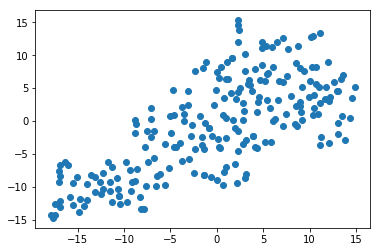

In [72]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [63]:
clusters = 5
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)

In [64]:
movie_classes = [[] for i in range(clusters)]
for i in range(clusters):
    c_movies = np.argwhere(kmeans.labels_==i).flatten()
    for m in c_movies:
        movie_classes[i].append(movie_names[m])

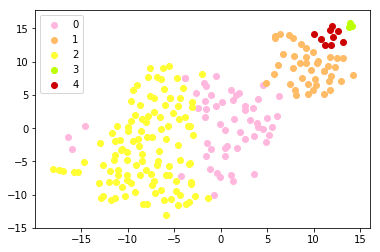

In [65]:
colors = ['#FFB7DD', '#FFBB66', '#FFFF33', '#BBFF00', '#CC0000', '#33CCFF', '#9999FF',
'#00AA55', '#E8CCFF', '#770077', '#FF7744', '#DDDDDD', '#444444']
labels = np.arange(0, clusters)
for i in range(clusters):
    idx = np.argwhere(kmeans.labels_==i)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=str(labels[i]))
plt.legend()
plt.show()

In [32]:
def get_recommend(movie_id):
    movie_vec = X[movie_id]
    scores = []
    for i in range(movie_size):
        score = cosine_similarity(movie_vec.reshape(1, -1), X[i].reshape(1, -1))
        scores.append(score[0])
    rank_names = np.argsort(np.array(scores).flatten())
    rank_scores = np.sort(np.array(scores).flatten())
    return movie_names[rank_names[-20:]], rank_scores[-20:]

In [66]:
# np.save('X', X)
# np.save('movie_names', movie_names)

In [33]:
get_recommend(16)

(array(['神鬼第六感', '七夜怪談西洋篇', '安娜貝爾', '星際效應', '陰兒房', '驚爆焦點', '控制', '海邊的曼徹斯特',
        '牠', '迷霧驚魂', '夏洛克福爾摩斯', '厲陰宅2', '駭客任務', '黑暗騎士', '黑天鵝', '陰兒房2',
        '沉默之丘', '沈默之丘', '逃出絕命鎮', '孤兒怨'],
       dtype='<U34'),
 array([ 0.66652861,  0.66652861,  0.6688455 ,  0.66965351,  0.67039613,
         0.67281031,  0.68109614,  0.69089165,  0.70393102,  0.71286764,
         0.71468233,  0.72343791,  0.73240496,  0.73321909,  0.73330797,
         0.7941528 ,  0.79523063,  0.79523063,  0.8341803 ,  1.        ]))